# Evalutating Geneformer in zero-shot setting - 23/07/2025

In [7]:
# Set up cache directories for local storage
import os

# Set environment variables for local cache directories
os.environ["PIP_CACHE_DIR"] = "./cache/pip"
os.environ["HF_HOME"] = "./cache/huggingface"
os.environ["TRANSFORMERS_CACHE"] = "./cache/transformers"
os.environ["MPLCONFIGDIR"] = "./cache/matplotlib"

# Create cache directories if they don't exist
cache_dirs = [
    "./cache/pip",
    "./cache/huggingface", 
    "./cache/transformers",
    "./cache/matplotlib"
]

for cache_dir in cache_dirs:
    os.makedirs(cache_dir, exist_ok=True)

print("Cache directories set up:")
print(f"PIP_CACHE_DIR: {os.environ.get('PIP_CACHE_DIR')}")
print(f"HF_HOME: {os.environ.get('HF_HOME')}")
print(f"TRANSFORMERS_CACHE: {os.environ.get('TRANSFORMERS_CACHE')}")
print(f"MPLCONFIGDIR: {os.environ.get('MPLCONFIGDIR')}")

Cache directories set up:
PIP_CACHE_DIR: ./cache/pip
HF_HOME: ./cache/huggingface
TRANSFORMERS_CACHE: ./cache/transformers
MPLCONFIGDIR: ./cache/matplotlib


In [13]:
import os
import logging
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import geneformer_ensemble_metrics
from sc_foundation_evals import data, cell_embeddings, model_output
from sklearn.preprocessing import LabelEncoder

from sc_foundation_evals.helpers.custom_logging import log
log.setLevel(logging.INFO)

## Setting up variables

Define some variables, that we will rely on later, starting with paths and run configs.

In [12]:
geneformer_data = "../data/weights/Geneformer"
# path to the pre-trained model, can work with the huggingface model hub
# i.e. ctheodoris/Geneformer
model_dir = "../Geneformer/Geneformer-V2-104M_CLcancer"
# path to dictionaries in geneformer repo - use V2-specific dictionaries
dict_dir = "../Geneformer/geneformer"  # Changed to use V2 dictionaries

Alternatively to the code above, you can also use the snippet below, using the copy of the Genefomerme repository.

```python
repo_dir = "/path/to/repository/of/Geneformer"
model_dir = os.path.join(repo_dir)
dict_dir = os.path.join(repo_dir, "geneformer")
```

In [3]:
# batch_size depends on available GPU memory
batch_size = 24
# output_dir is the path to which the results should be saved
output_dir = "../output/geneformer/6L/"
# path to where we will store the embeddings and other evaluation outputs
model_out = os.path.join(output_dir, "model_outputs")
# if you can use multithreading specify num_workers, -1 means use all available
num_workers = -1

Data paths and configs.

I will be using the Pancreas dataset as an example, as described in the scGPT_zer-shot notebook.

In [14]:
# specify the path to anndata object
in_dataset_path = "../data/datasets/integrated_with_quiescence.h5ad"
# in_dataset_path = "../data/datasets/integrated_with_quiescence_subset.h5ad"
# dataset_name is inferred from in_dataset_path
dataset_name = os.path.basename(in_dataset_path).split(".")[0]
# specify the path for the output of the pre-processing
preprocessed_path = f"../data/datasets/geneformer/{dataset_name}/"
# create the preprocessed path if it does not exist
os.makedirs(preprocessed_path, exist_ok=True)
# in which column in adata.obs are gene names stored? if they are in index, the index will be copied to a column with this name
gene_col = "gene_symbols"  # This will copy the index to a column named "gene_symbols"
# batch column found in adata.obs
batch_col = "orig.ident"  # Your batch information
# where are labels stored in adata.obs? 
label_col = "celltype"  # Your cell type labels
# where the raw counts are stored?
layer_key = "X"  # Changed from "counts" to "X" - use the main data matrix

In [ ]:
# import scanpy as sc
# adata = sc.read_h5ad("../data/datasets/integrated_with_quiescence.h5ad")
# # Take first 1000 cells for testing
# adata_subset = adata[:1000, :].copy()
# sc.write("../data/datasets/integrated_with_quiescence_subset.h5ad", adata_subset)

In [ ]:
# import scanpy as sc
# adata = sc.read_h5ad("../data/datasets/integrated_with_quiescence.h5ad")
# print("var columns:", adata.var.columns.tolist())
# print("var index (first 5):", adata.var.index[:5].tolist())

var columns: []
var index (first 5): ['RP11-34P13.7', 'RP11-34P13.8', 'FO538757.3', 'FO538757.2', 'AP006222.2']


## Loading model and data

In [15]:
geneform = gf.Geneformer_instance(save_dir = output_dir, 
                                  saved_model_path = model_dir,
                                  explicit_save_dir = True,
                                  num_workers = num_workers)

INFO     | 2025-07-31 09:30:53 | Using device cuda


In [16]:
geneform.load_pretrained_model()

INFO     | 2025-07-31 09:30:55 | Model successfully loaded from ../Geneformer/Geneformer-V2-104M_CLcancer


Load them vocabulary and gene to Ensembl ID matching.

In [17]:
geneform.load_vocab(dict_dir)

To prepare the data, we need to preprocess it and then tokenize it. First, we create the input data objec.

In [9]:
input_data = data.InputData(adata_dataset_path = in_dataset_path)

INFO     | 2025-07-30 22:20:43 | Loading data from ../data/datasets/integrated_with_quiescence.h5ad


Then, we preprocess the data - match gene names and filter cells and genes. This will create a new adata, that will be saved in the `preprocessed_path` to a `.loom` or `.h5ad` file. Loom data seems to be causing more issues in this version of the Geneformer code, so I'll stick with this, but overall this should also work with adata format.

In [82]:
input_data.preprocess_data(gene_col = gene_col,
                           model_type = "geneformer",
                           save_ext = "loom",
                           gene_name_id_dict = geneform.gene_name_id,
                           preprocessed_path = preprocessed_path)

WARNING  | 2025-07-30 21:53:09 | Gene names not found in var columns. Using index instead.


INFO     | 2025-07-30 21:53:09 | Matched 87.34% genes (13411/15355) genes in vocabulary of size 40248.


Now, tokenizing the data. Preprocessing saves the data to a file, as the tokenizer expects to read it from drive. This will create a `dataset_name`.dataset directory with the tokenized data in the `preprocessed_path`. This will also read in the tokenized_data to the `geneform` object.

In [ ]:
# import scanpy as sc
# adata = sc.read_h5ad("../data/datasets/integrated_with_quiescence.h5ad")
# print("layers:", list(adata.layers.keys()) if hasattr(adata, 'layers') else "No layers")
# print("adata.X shape:", adata.X.shape)
# print("adata.X type:", type(adata.X))

layers: ['logcounts']
adata.X shape: (138727, 33541)
adata.X type: <class 'scipy.sparse._csc.csc_matrix'>


In [ ]:
geneform.tokenize_data(adata_path = os.path.join(preprocessed_path, 
                                                 f"{dataset_name}.loom"),
                       dataset_path = preprocessed_path,
                       cell_type_col = label_col)


If the data was already tokenized, we can just load it.

```python
geneform.load_tokenized_dataset(os.path.join(preprocessed_path, f"{dataset_name}.dataset"))
input_data = data.InputData(adata_dataset_path = os.path.join(preprocessed_path, f"{dataset_name}.loom"))
```

In [19]:
geneform.load_tokenized_dataset(os.path.join(preprocessed_path, f"{dataset_name}.dataset"))
input_data = data.InputData(adata_dataset_path = os.path.join(preprocessed_path, f"{dataset_name}.loom"))

INFO     | 2025-07-31 09:31:52 | Loading data from ../data/datasets/geneformer/integrated_with_quiescence/integrated_with_quiescence.loom


## Evaluating model outputs

First, we will perform forward pass on the model and extract embeddings. We're interested with second to last layer, as per the instructions in the codebase of Geneformer [here](https://huggingface.co/ctheodoris/Geneformer/blob/main/geneformer/emb_extractor.py#L285). Using the argument `layer` we can refer to layers according to python logic (i.e. 0 is the embedding layer, 1 - first layer, 2 is the second layer, etc. and -1 is the last layer, etc.).

*Note:* If you get a CUDA out of memory error, you can try reducing the batch size. As a rule of thumb, try batch sizes of multiples of 8, to avoid potential issues with how approximations are handled in CUDA.

In [21]:
# Create input_data object for compatibility
import scanpy as sc
adata = sc.read_h5ad("../data/datasets/integrated_with_quiescence.h5ad")
input_data = data.InputData(adata_dataset_path = in_dataset_path)

# Extract embeddings
geneform.extract_embeddings(data = input_data,
                            batch_size = batch_size, 
                            layer = -2)

INFO     | 2025-07-31 09:44:19 | Loading data from ../data/datasets/integrated_with_quiescence.h5ad
Geneformer (extracting embeddings): 100%|██████████| 5781/5781 [3:52:26<00:00,  2.41s/it]  


In [22]:
eval_ce = cell_embeddings.CellEmbeddingsEval(geneform,
                                             data = input_data,  # Use the same input_data from step 3
                                             output_dir = model_out,
                                             label_key = label_col,
                                             batch_key = batch_col)

In [23]:
   # Create the gene expression prediction evaluation
eval_pred = model_output.GeneExprPredEval(geneform, 
                                             output_dir = model_out)

In [24]:
eval_pred.evaluate(n_cells = 500,
                   save_rankings = True)

,correlation,mean_correlation
count,500.000000,500.000000
mean,0.983860,0.499950
std,0.010962,0.114228
min,0.936994,-0.079253
25%,0.977592,0.455095
50%,0.985061,0.516958
75%,0.991782,0.577334
max,1.000000,0.662875


In [25]:
!pip install louvain

INFO     | 2025-07-31 13:45:33 | Subsetting to 100 cells


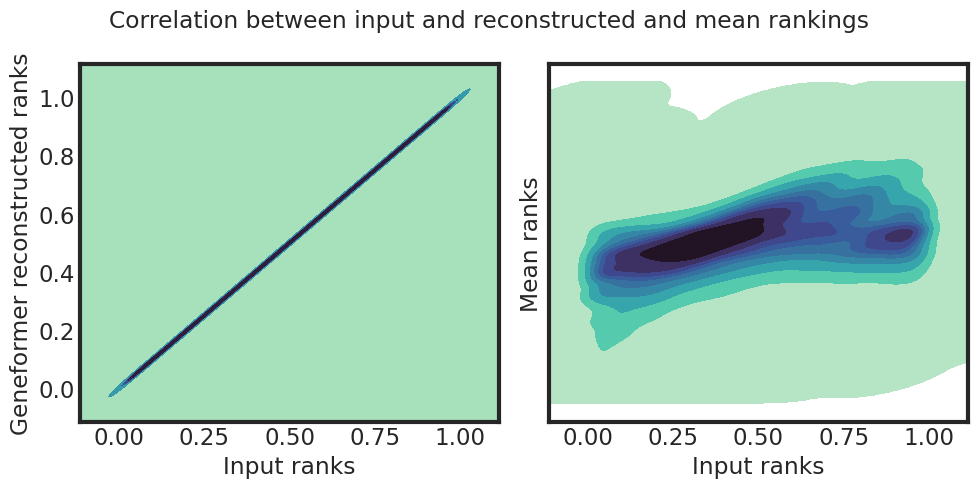

In [26]:
eval_pred.visualize(n_cells = 100, cmap = "mako_r")

# Evaluate the cell embeddings

First, creating cell embeddings evaluation object.

In [27]:
eval_ce = cell_embeddings.CellEmbeddingsEval(geneform,
                                             data = input_data,
                                             output_dir = model_out,
                                             label_key = label_col,
                                             batch_key = batch_col)


Then, evaluating the embeddings. Here, for speed we are subsetting the data to 1000 cells.

In [28]:
# with n_cells you can specify how much to subset the obs for
eval_ce.evaluate(n_cells = 1000, embedding_key = "geneformer")

WARNING  | 2025-07-31 13:47:13 | adata_ has 138727 cells. Taking a subset of 1000 cells.


,metric,label,value
0,NMI_cluster/label,celltype,0.378537
1,ARI_cluster/label,celltype,0.188819
2,ASW_label,celltype,0.461430
3,graph_conn,celltype,0.742903
4,ASW_batch,celltype,0.546254
5,ASW_label/batch,celltype,0.738082
6,PCR_batch,celltype,0.103883
7,avg_bio,celltype,0.342929


In [29]:
# with n_cells you can specify how much to subset the obs for
eval_ce.evaluate(n_cells = 1000, embedding_key = "geneformer")

WARNING  | 2025-07-31 13:47:22 | adata_ has 138727 cells. Taking a subset of 1000 cells.


,metric,label,value
0,NMI_cluster/label,celltype,0.378537
1,ARI_cluster/label,celltype,0.188819
2,ASW_label,celltype,0.461430
3,graph_conn,celltype,0.742903
4,ASW_batch,celltype,0.546254
5,ASW_label/batch,celltype,0.738082
6,PCR_batch,celltype,0.103883
7,avg_bio,celltype,0.342929


WARNING  | 2025-07-31 13:48:55 | adata_ has 138727 cells. Taking a subset of 7500 cells.
WARNING  | 2025-07-31 13:48:56 | More than 10 labels for celltype.The plots might be hard to read.


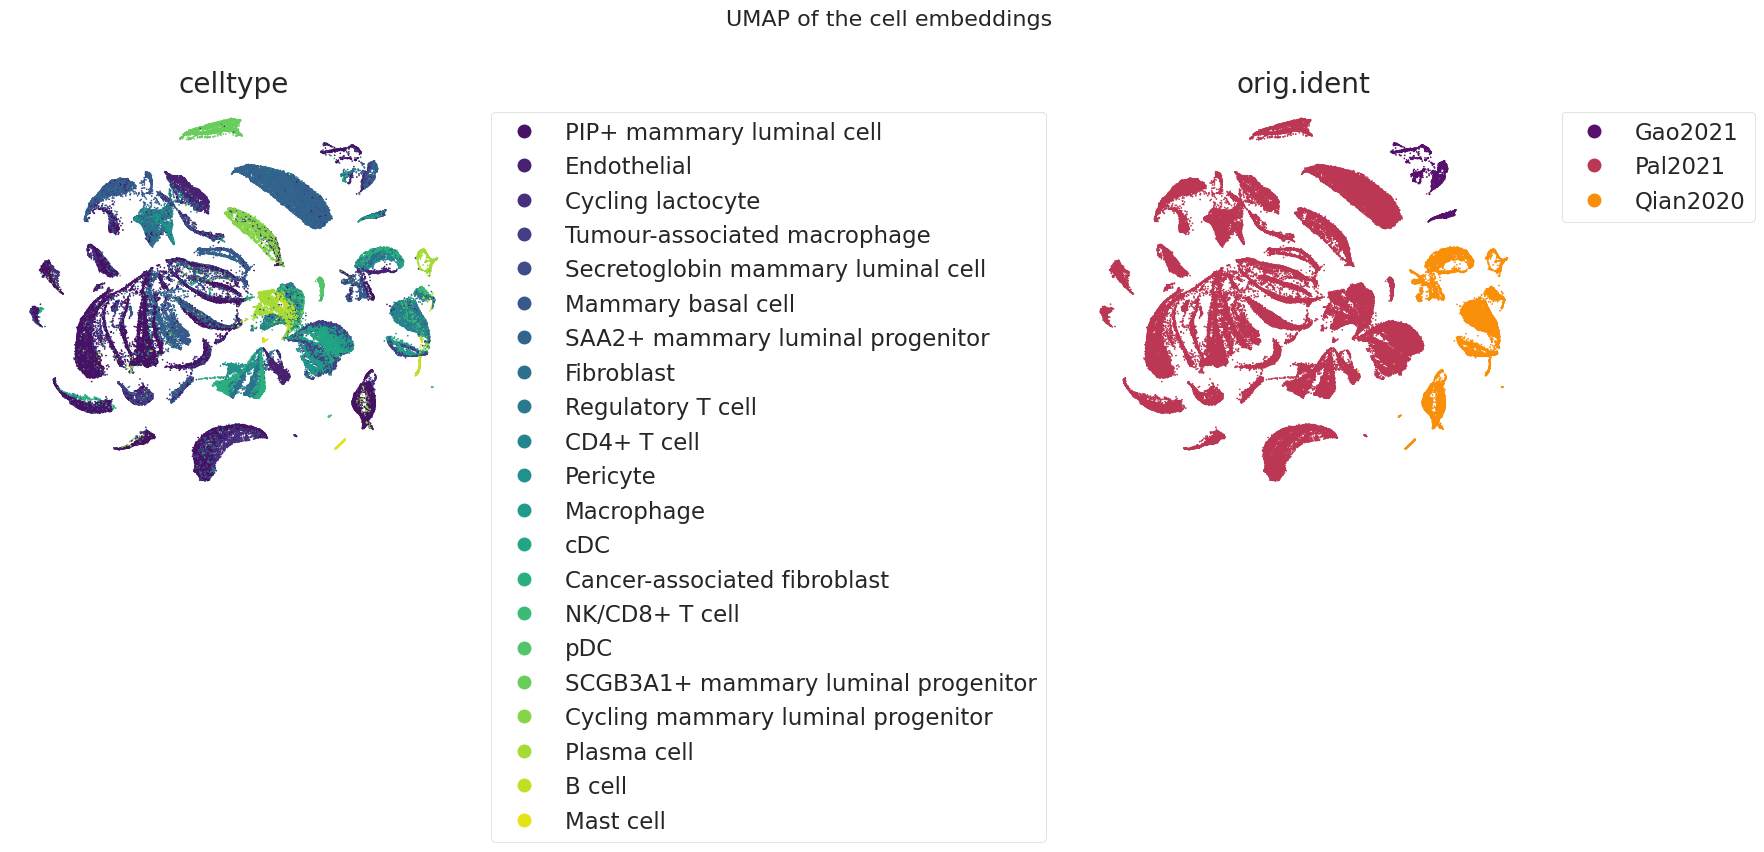

In [30]:
eval_ce.visualize(embedding_key = "geneformer")

In [31]:
# Simplified Geneformer Ensemble Evaluation (Embeddings Only)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    average_precision_score
)
from sklearn.preprocessing import LabelEncoder
from sc_foundation_evals import geneformer_ensemble_metrics

print("="*80)
print("SIMPLIFIED GENEFORMER ENSEMBLE EVALUATION (Embeddings Only)")
print("="*80)

# Create ensemble evaluation object
em = geneformer_ensemble_metrics.create_geneformer_ensemble_evaluation(
    geneform_instance=geneform,
    input_data=input_data,
    label_col=label_col,  # Your cell type column name
    output_dir=model_out  # Your output directory
)

print(f"\nEnsemble evaluation object created!")
print(f"Number of cells: {len(em.embeddings)}")
print(f"Embedding dimension: {em.embeddings.shape[1]}")
print(f"Number of cell types: {len(em.class_names)}")

# Evaluate with embedding-only method (should work reliably)
print(f"\nEvaluating with embedding-only method...")
try:
    embedding_result = em.evaluate_ensemble(alpha=1.0, method='embedding_only')
    print(f"Embedding-only evaluation successful!")
    print(f"  F1-Score: {embedding_result['f1_score']:.3f}")
    print(f"  AUC-ROC: {embedding_result['auc_roc']:.3f}")
    print(f"  Accuracy: {embedding_result['accuracy']:.3f}")
    print(f"  Precision: {embedding_result['precision']:.3f}")
    print(f"  Recall: {embedding_result['recall']:.3f}")
except Exception as e:
    print(f"Embedding-only evaluation failed: {e}")
    import traceback
    traceback.print_exc()

# Try different alpha values with embedding-only method
print(f"\nEvaluating different alpha values with embedding-only method...")
alphas = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
results = {}

for alpha in alphas:
    try:
        result = em.evaluate_ensemble(alpha=alpha, method='embedding_only')
        results[alpha] = result
        print(f"  Alpha {alpha}: F1={result['f1_score']:.3f}, AUC-ROC={result['auc_roc']:.3f}")
    except Exception as e:
        print(f"  Alpha {alpha}: Failed - {e}")

if results:
    # Find best alpha
    best_alpha = max(results.keys(), key=lambda x: results[x]['f1_score'])
    best_result = results[best_alpha]
    
    print(f"\nBest Configuration:")
    print(f"  Alpha: {best_alpha}")
    print(f"  F1-Score: {best_result['f1_score']:.3f}")
    print(f"  AUC-ROC: {best_result['auc_roc']:.3f}")
    print(f"  Accuracy: {best_result['accuracy']:.3f}")
    
    # Per-class analysis
    print(f"\nPer-class F1 scores:")
    for class_name, f1_score in best_result['per_class_f1'].items():
        print(f"  {class_name}: {f1_score:.3f}")
    
    print(f"\nPer-class AUC-ROC scores:")
    for class_name, auc_roc in best_result['per_class_auc_roc'].items():
        print(f"  {class_name}: {auc_roc:.3f}")
    
    # Create simple comparison plot
    # print(f"\nCreating performance comparison plot...")
    # try:
    #     fig, ax = plt.subplots(figsize=(10, 6))
        
    #     alphas_list = list(results.keys())
    #     f1_scores = [results[alpha]['f1_score'] for alpha in alphas_list]
    #     auc_scores = [results[alpha]['auc_roc'] for alpha in alphas_list]
        
    #     ax.plot(alphas_list, f1_scores, 'o-', label='F1-Score', linewidth=2, markersize=8)
    #     ax.plot(alphas_list, auc_scores, 's-', label='AUC-ROC', linewidth=2, markersize=8)
        
    #     ax.set_xlabel('Alpha (Weight for Embeddings)')
    #     ax.set_ylabel('Score')
    #     ax.set_title('Geneformer Embedding Performance')
    #     ax.legend()
    #     ax.grid(True, alpha=0.3)
    #     plt.tight_layout()
    #     plt.show()
        
    #     # Confusion matrix for best alpha
    #     print(f"\nCreating confusion matrix for best alpha ({best_alpha})...")
    #     try:
    #         predictions, _ = em.create_ensemble_predictions(alpha=best_alpha, method='embedding_only')
    #         cm = confusion_matrix(em.labels_encoded, predictions)
            
    #         fig, ax = plt.subplots(figsize=(12, 10))
    #         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
    #                    xticklabels=em.class_names, 
    #                    yticklabels=em.class_names, ax=ax)
    #         ax.set_title(f'Confusion Matrix - Embedding Only (α={best_alpha})')
    #         ax.set_xlabel('Predicted')
    #         ax.set_ylabel('Actual')
    #         plt.tight_layout()
    #         plt.show()
    #     except Exception as e:
    #         print(f"Could not create confusion matrix: {e}")
            
    # except Exception as e:
    #     print(f"Could not create performance plot: {e}")
    
    # Save results
    print(f"\nSaving results...")
    try:
        summary_data = []
        for alpha, result in results.items():
            row = {
                'Alpha': alpha,
                'Method': 'embedding_only',
                'Accuracy': result['accuracy'],
                'Precision': result['precision'],
                'Recall': result['recall'],
                'F1_Score': result['f1_score'],
                'AUC_ROC': result['auc_roc'],
                'Avg_Precision': result['avg_precision']
            }
            summary_data.append(row)
        
        df = pd.DataFrame(summary_data)
        output_path = os.path.join(model_out, 'geneformer_embedding_metrics.csv')
        df.to_csv(output_path, index=False)
        print(f"Results saved to: {output_path}")
    except Exception as e:
        print(f"Could not save results: {e}")
    
    # Final summary
#     print(f"\n" + "="*80)
#     print("FINAL EMBEDDING-ONLY EVALUATION SUMMARY")
#     print("="*80)
#     print(f"Dataset: {dataset_name}")
#     print(f"Model: Geneformer-V2-104M_CLcancer")
#     print(f"Total cells: {len(em.embeddings)}")
#     print(f"Cell types: {len(em.class_names)}")
#     print(f"Embedding dimension: {em.embeddings.shape[1]}")
#     print(f"Best Alpha: {best_alpha}")
#     print(f"Best F1-Score: {best_result['f1_score']:.3f}")
#     print(f"Best AUC-ROC: {best_result['auc_roc']:.3f}")
#     print(f"Best Accuracy: {best_result['accuracy']:.3f}")
#     print("="*80)
#     print("EMBEDDING-ONLY EVALUATION COMPLETE! ��")
#     print("="*80)
# else:
#     print("No successful evaluations. Check the error messages above.")

INFO     | 2025-07-31 13:48:59 | Initialized GeneformerEnsembleMetrics with 138727 cells and 21 classes
INFO     | 2025-07-31 13:48:59 | Classes: ['B cell', 'CD4+ T cell', 'Cancer-associated fibroblast', 'Cycling lactocyte', 'Cycling mammary luminal progenitor', 'Endothelial', 'Fibroblast', 'Macrophage', 'Mammary basal cell', 'Mast cell', 'NK/CD8+ T cell', 'PIP+ mammary luminal cell', 'Pericyte', 'Plasma cell', 'Regulatory T cell', 'SAA2+ mammary luminal progenitor', 'SCGB3A1+ mammary luminal progenitor', 'Secretoglobin mammary luminal cell', 'Tumour-associated macrophage', 'cDC', 'pDC']
INFO     | 2025-07-31 13:48:59 | Embedding shape: (138727, 768)
INFO     | 2025-07-31 13:48:59 | Input rankings length: 138727
INFO     | 2025-07-31 13:48:59 | Output rankings length: 138727


SIMPLIFIED GENEFORMER ENSEMBLE EVALUATION (Embeddings Only)

Ensemble evaluation object created!
Number of cells: 138727
Embedding dimension: 768
Number of cell types: 21

Evaluating with embedding-only method...


INFO     | 2025-07-31 13:49:00 | Evaluated embedding_only (α=1.0): Accuracy=0.485, F1=0.529, AUC-ROC=0.771


Embedding-only evaluation successful!
  F1-Score: 0.529
  AUC-ROC: 0.771
  Accuracy: 0.485
  Precision: 0.670
  Recall: 0.485

Evaluating different alpha values with embedding-only method...


INFO     | 2025-07-31 13:49:01 | Evaluated embedding_only (α=0.0): Accuracy=0.485, F1=0.529, AUC-ROC=0.771


  Alpha 0.0: F1=0.529, AUC-ROC=0.771


INFO     | 2025-07-31 13:49:02 | Evaluated embedding_only (α=0.1): Accuracy=0.485, F1=0.529, AUC-ROC=0.771


  Alpha 0.1: F1=0.529, AUC-ROC=0.771


INFO     | 2025-07-31 13:49:03 | Evaluated embedding_only (α=0.3): Accuracy=0.485, F1=0.529, AUC-ROC=0.771


  Alpha 0.3: F1=0.529, AUC-ROC=0.771


INFO     | 2025-07-31 13:49:05 | Evaluated embedding_only (α=0.5): Accuracy=0.485, F1=0.529, AUC-ROC=0.771


  Alpha 0.5: F1=0.529, AUC-ROC=0.771


INFO     | 2025-07-31 13:49:06 | Evaluated embedding_only (α=0.7): Accuracy=0.485, F1=0.529, AUC-ROC=0.771


  Alpha 0.7: F1=0.529, AUC-ROC=0.771


INFO     | 2025-07-31 13:49:07 | Evaluated embedding_only (α=0.9): Accuracy=0.485, F1=0.529, AUC-ROC=0.771


  Alpha 0.9: F1=0.529, AUC-ROC=0.771


INFO     | 2025-07-31 13:49:08 | Evaluated embedding_only (α=1.0): Accuracy=0.485, F1=0.529, AUC-ROC=0.771


  Alpha 1.0: F1=0.529, AUC-ROC=0.771

Best Configuration:
  Alpha: 0.0
  F1-Score: 0.529
  AUC-ROC: 0.771
  Accuracy: 0.485

Per-class F1 scores:
  B cell: 0.377
  CD4+ T cell: 0.545
  Cancer-associated fibroblast: 0.726
  Cycling lactocyte: 0.182
  Cycling mammary luminal progenitor: 0.275
  Endothelial: 0.593
  Fibroblast: 0.461
  Macrophage: 0.317
  Mammary basal cell: 0.230
  Mast cell: 0.183
  NK/CD8+ T cell: 0.364
  PIP+ mammary luminal cell: 0.574
  Pericyte: 0.728
  Plasma cell: 0.706
  Regulatory T cell: 0.622
  SAA2+ mammary luminal progenitor: 0.613
  SCGB3A1+ mammary luminal progenitor: 0.929
  Secretoglobin mammary luminal cell: 0.291
  Tumour-associated macrophage: 0.549
  cDC: 0.600
  pDC: 0.841

Per-class AUC-ROC scores:
  B cell: 0.718
  CD4+ T cell: 0.943
  Cancer-associated fibroblast: 0.722
  Cycling lactocyte: 0.647
  Cycling mammary luminal progenitor: 0.854
  Endothelial: 0.701
  Fibroblast: 0.686
  Macrophage: 0.731
  Mammary basal cell: 0.526
  Mast cell: 0.958